# Optimisation: Spotting unidentifiable parameters with MCMC

As well as minimising error functions, PINTS optimisers can be used to maximise likelihoods (or actually any [LogPDF](https://pints.readthedocs.io/en/latest/log_pdfs.html#pints.LogPDF)).

This makes it easy to combine optimisation and sampling. For example, you may have found a best solution through optimisation, but suspect it is not unique. You could then run an MCMC (or other sampling) routine to explore the space around your best solution. This is particularly useful when the parameter space is large, so that MCMC on its own might be too computationally demanding.

First, we need a model without a unique best parameter set. To get this, we'll adapt the logistic model from pints set of toy models and:

- Fix the growth rate
- Set the carrying capacity to $k = 41 + \sqrt{k_1^2 + k_2^2}$
- Set the parameters to be $k_1$ and $k_2$

with these modifications we've lost one parameter and one degree of freedom (fixed growth rate), but the carrying capacity (a single number) is now described by two parameters.
As as result, there are infinitely many combinations of $k_1$ and $k_2$ that will give the same result.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.plot


class BadLogisticModel(pints.ForwardModel):
    """
    Logistic model of population growth with unidentifiable parameters.
    """

    def __init__(self):
        super(BadLogisticModel, self).__init__()
        
        # Initial population size
        self._p0 = 2
        
        # Fixed growth rate
        self._r = 0.1
        
    def n_parameters(self):
        return 2

    def simulate(self, parameters, times):
        
        k1, k2 = parameters
        times = np.asarray(times)

        # Combine k1 and k2 into a single parameter, k
        k = 41 + np.sqrt(k1**2 + k2**2)
        
        return k / (1 + (k / self._p0 - 1) * np.exp(-self._r * times))

We can still easily generate some data:

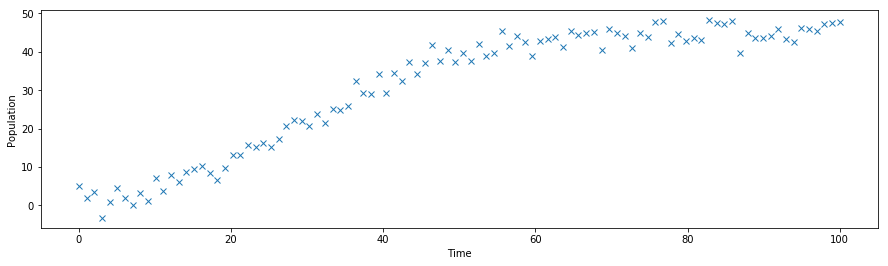

In [2]:
model = BadLogisticModel()

real_parameters = [3, 3]
times = np.linspace(0, 100, 100)

experiment = model.simulate(real_parameters, times)

sigma_noise = 2
noisy_experiment = experiment + np.random.normal(0, sigma_noise, size=experiment.shape)

plt.figure(figsize=(15, 4))
plt.xlabel('Time')
plt.ylabel('Population')
plt.plot(times, noisy_experiment, 'x')
plt.show()

And we can define a log likelihood, and use optimisation to try and find back these parameters

In [3]:
problem = pints.SingleOutputProblem(model, times, noisy_experiment)

log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, sigma_noise)

opt = pints.OptimisationController(log_likelihood, [6, 2], method=pints.XNES)
opt.set_log_to_screen(False)
x1, f1 = opt.run()

print('Found solution with loglikelihood ' + str(f1))
print(x1)

Found solution with loglikelihood -216.7153062998382
[2.91546348 3.01776749]


We can inspect the simulated output:

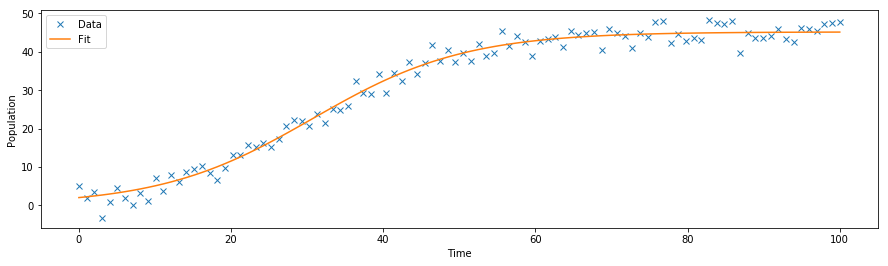

In [4]:
plt.figure(figsize=(15, 4))
plt.xlabel('Time')
plt.ylabel('Population')
plt.plot(times, noisy_experiment, 'x', label='Data')
plt.plot(times, model.simulate(x1, times), label='Fit')
plt.legend()
plt.show()

It looks fine, but what happens if we run it again?

Found solution with loglikelihood -216.7153062998382
[-0.00906677  4.19604168]


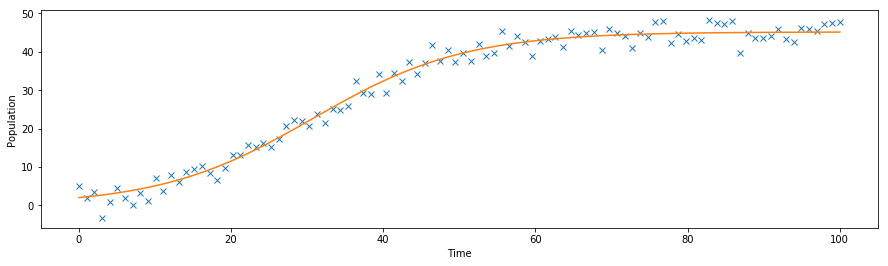

In [5]:
opt = pints.OptimisationController(log_likelihood, [2, 6], method=pints.XNES)
opt.set_log_to_screen(False)
x2, f2 = opt.run()

print('Found solution with loglikelihood ' + str(f2))
print(x2)

plt.figure(figsize=(15, 4))
plt.xlabel('Time')
plt.ylabel('Population')
plt.plot(times, noisy_experiment, 'x')
plt.plot(times, model.simulate(x2, times))
plt.show()

So now we have two very different solutions, but both give an excellent fit.
This could cause all sorts of problems if we wanted to ascribe some sort of meaning to the parameters we found.

Let's do it again!

Found solution with loglikelihood -216.7153062998382
[2.63406263 3.2662764 ]


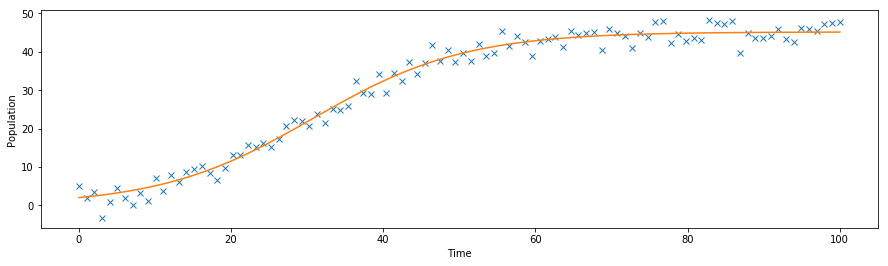

In [6]:
opt = pints.OptimisationController(log_likelihood, [2, 6], method=pints.XNES)
opt.set_log_to_screen(False)
x3, f3 = opt.run()

print('Found solution with loglikelihood ' + str(f3))
print(x3)

plt.figure(figsize=(15, 4))
plt.xlabel('Time')
plt.ylabel('Population')
plt.plot(times, noisy_experiment, 'x')
plt.plot(times, model.simulate(x3, times))
plt.show()

We now try out a bit of MCMC, to see what's going on in the parameter space:

In [7]:
mcmc = pints.MCMCController(log_likelihood, 3, [x1, x2, x3])
mcmc.set_max_iterations(6000)
mcmc.set_log_to_screen(False)
chains = mcmc.run()

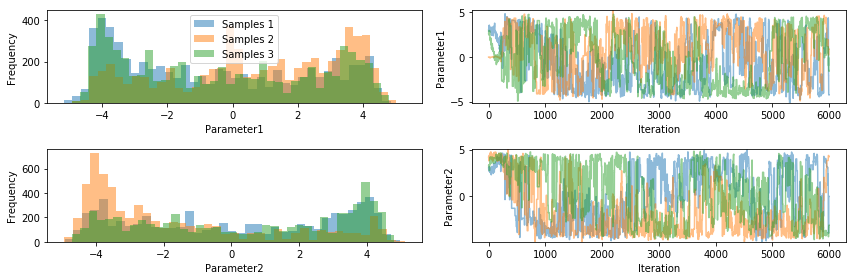

In [8]:
# Show traces and histograms
pints.plot.trace(chains)
plt.show()

We can see from the histograms that the chains are moving over a wide area, and in the plots on the right we see the same.

Finally, we can make a plot of our parameters, and look for any correlations:

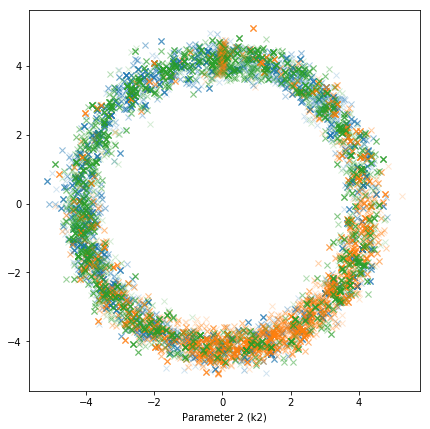

In [11]:
plt.figure(figsize=(7, 7))
plt.xlabel('Parameter 1 (k1)')
plt.ylabel('Parameter 2 (k2)')
plt.plot(chains[0, :, 0], chains[0, :, 1], 'x', alpha=0.2)
plt.plot(chains[1, :, 0], chains[1, :, 1], 'x', alpha=0.2)
plt.plot(chains[2, :, 0], chains[2, :, 1], 'x', alpha=0.2)
plt.show()

We can now get a good idea of what's going on: The parameters $k_1$ and $k_2$ form a ring in parameter space, along which model output is identical. Using sampling allowed us to spot this error in our model formulation.

Note however, that the default adaptive method doesn't always do a great job of finding the _full_ circle, so that some experimentation with others methods might be required.